In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import equinox as eqx

import optax

import timeit

from scipy.stats import qmc

In [14]:
model_key = jax.random.PRNGKey(1)

input_dim = 2
output_dim = 'scalar'

layers_size = 10
n_layers = 1

model = eqx.nn.MLP(in_size=input_dim, out_size=output_dim, width_size=layers_size, depth=n_layers,
                    activation=jax.nn.sigmoid, use_final_bias=False, key=model_key)

In [15]:
sigma2 = 0.5**2

L = 3.0


a = 0.9
b = 0.975

v_max = 1.5
p_max = 1 # rho_max cannot be learned Susana's paper

In [16]:
# Example batch input

batch_input_data = jnp.array([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0]
])

In [17]:
jax.vmap(model)(batch_input_data)

Array([-0.7031001 , -0.69159174, -0.7158083 ], dtype=float32)

In [18]:
def cosine_spacing(start, end, steps):
    linspace = jnp.linspace(0, jnp.pi, steps)
    cosine_values = (1 - jnp.cos(linspace))/2  # This maps the values to [0, 1]
    return start + (end - start) * cosine_values

In [19]:
import itertools

In [20]:
    x_flat = cosine_spacing(0, 5, 10)
    vm_flat = jnp.linspace(1, 3, 10)

    inputs = jnp.array(list(itertools.product(x_flat, vm_flat)))

In [21]:
inputs[:,1]

Array([1.       , 1.2222222, 1.4444444, 1.6666667, 1.888889 , 2.1111112,
       2.3333333, 2.5555558, 2.777778 , 3.       , 1.       , 1.2222222,
       1.4444444, 1.6666667, 1.888889 , 2.1111112, 2.3333333, 2.5555558,
       2.777778 , 3.       , 1.       , 1.2222222, 1.4444444, 1.6666667,
       1.888889 , 2.1111112, 2.3333333, 2.5555558, 2.777778 , 3.       ,
       1.       , 1.2222222, 1.4444444, 1.6666667, 1.888889 , 2.1111112,
       2.3333333, 2.5555558, 2.777778 , 3.       , 1.       , 1.2222222,
       1.4444444, 1.6666667, 1.888889 , 2.1111112, 2.3333333, 2.5555558,
       2.777778 , 3.       , 1.       , 1.2222222, 1.4444444, 1.6666667,
       1.888889 , 2.1111112, 2.3333333, 2.5555558, 2.777778 , 3.       ,
       1.       , 1.2222222, 1.4444444, 1.6666667, 1.888889 , 2.1111112,
       2.3333333, 2.5555558, 2.777778 , 3.       , 1.       , 1.2222222,
       1.4444444, 1.6666667, 1.888889 , 2.1111112, 2.3333333, 2.5555558,
       2.777778 , 3.       , 1.       , 1.2222222, 

In [26]:
def loss(model, sigma2, L, a, b, steps=50):

    x_flat = cosine_spacing(0, L, steps)
    x_flat = jnp.concat([x_flat, jnp.array([0.0]), jnp.array([L])])
    vm_flat = jnp.linspace(1, 2, steps)

    inputs = jnp.array(list(itertools.product(x_flat, vm_flat)))
    

    rho, grad = jax.vmap(jax.value_and_grad(model))(inputs)
    hess = jax.vmap(jax.hessian(model))(inputs)

    dp_dx = grad[:, 0]
    d2p_dx2 = hess[:, 0, 0]

    # PDE Loss
    pde_loss = sigma2*d2p_dx2 - dp_dx*(inputs[:, 1]*(1-2*rho))

    # Vm

    # in loss
    in_loss = sigma2*dp_dx[-2*steps:-steps] - rho[-2*steps:-steps]*inputs[-2*steps:-steps, 1]*(1-rho[-2*steps:-steps]) + a*(1-rho[-2*steps:-steps])

    # out loss
    out_loss = -sigma2*dp_dx[-steps:] + rho[-steps:]*inputs[-steps:, 1]*(1-rho[-steps]) - b*rho[-steps:]

    return jnp.average(pde_loss**2) + jnp.average(in_loss**2) + jnp.average(out_loss**2)


In [27]:
x_flat = cosine_spacing(0, L, 6)
vm_flat = jnp.linspace(1, 3, 5)

inputs = jnp.array(list(itertools.product(x_flat, vm_flat)))

In [28]:
inputs[1:3,2]

Array([1.5, 2. ], dtype=float32)

In [31]:
loss(model, 0.5**2, 3, a,b)

Array(19.75614, dtype=float32)

In [32]:
# Define a Multilayer Perceptron

class MLP(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.


    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the MLP

        Args:
            key (jax key): Random Jey
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (_type_): Number of hidden layers
            output_dim (_type_): Output layer dimension
        """


        
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 1)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

    
    def __call__(self, x):
        """Forward-pass the input through the network

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """
        for layer in self.layers[:-1]:
            x = jax.nn.mish(layer(x))
        
        x = self.layers[-1](x)
        return x

In [33]:
@eqx.filter_jit # decorator that applies Just-in-time compilation just to the relevant parts. Improves performance.
def train_step(model, opt_state, L, sigma2, a, b, steps=20):
    loss_value, grads = jax.value_and_grad(loss)(model, sigma2, L, a, b) # Compute the loss and gradient
    updates, opt_state = optimizer.update(grads, opt_state) # Apply the backward propagation
    model = eqx.apply_updates(model, updates) # Update the NN
    return model, opt_state, loss_value

In [39]:
# Initialize the model with multiple hidden layers and scalar output layer
model_key = jax.random.PRNGKey(1)

input_dim = 2
output_dim = 'scalar'

model = MLP(model_key, input_dim=input_dim, hidden_dims=4, n_layers=4, output_dim=output_dim)

In [40]:
# Optimizer definition
lr = 10e-4
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(model)

In [41]:
# Training loop
num_epochs = 30000
losses = []


for epoch in range(num_epochs):
    
    model, opt_state, loss_value = train_step(model, opt_state, L, sigma2, a, b, steps=50)

    if epoch % 100 == 0:
        losses.append(loss_value)
        print(f"Epoch {epoch}, Loss: {loss_value}")
        #sigma2 = ss[i]
        
    if epoch % 1000 == 0:
        lr *= 0.4
        optimizer = optax.adam(learning_rate=lr)
        opt_state = optimizer.init(model)  # Re-initialize optimizer state with new learning rate



# Print final loss
final_loss = loss(model, L, sigma2, a, b, steps=20)
print(f"Final Loss: {final_loss}")

Epoch 0, Loss: 4.1124677658081055
Epoch 100, Loss: 0.5551918148994446
Epoch 200, Loss: 0.03244084492325783
Epoch 300, Loss: 0.024174213409423828
Epoch 400, Loss: 0.02004927769303322
Epoch 500, Loss: 0.01708044856786728
Epoch 600, Loss: 0.014675945043563843
Epoch 700, Loss: 0.012667852453887463
Epoch 800, Loss: 0.010996297933161259
Epoch 900, Loss: 0.009624902158975601
Epoch 1000, Loss: 0.008518475107848644
Epoch 1100, Loss: 0.004761449061334133
Epoch 1200, Loss: 0.003837766358628869
Epoch 1300, Loss: 0.0032742819748818874
Epoch 1400, Loss: 0.002660582074895501
Epoch 1500, Loss: 0.002097367076203227
Epoch 1600, Loss: 0.0017990298802033067
Epoch 1700, Loss: 0.0016566698905080557
Epoch 1800, Loss: 0.0015622475184500217
Epoch 1900, Loss: 0.0015080170705914497
Epoch 2000, Loss: 0.0014741914346814156
Epoch 2100, Loss: 0.0014678024454042315
Epoch 2200, Loss: 0.0014596434775739908
Epoch 2300, Loss: 0.0014493855414912105
Epoch 2400, Loss: 0.0014374087331816554
Epoch 2500, Loss: 0.00142369326204

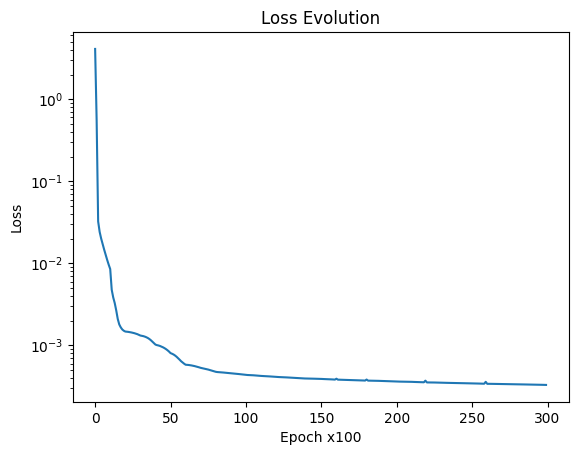

In [42]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch x100')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.show()

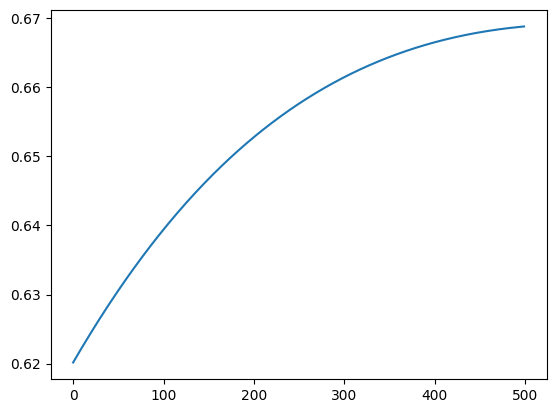

In [49]:
x_flat = jnp.linspace(0, L, 500)

v_max = 1.5

input = jnp.array([[x, v_max] for x in x_flat])

outputs = jax.vmap(model)(input)

plt.plot(outputs)
#plt.ylim([0.4, 0.6])
plt.show()